In [76]:
spark.stop()

In [1]:
core = 8
nome = "nicolò"
#nicolò
#marco
#francesco
#raffaele

In [2]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

#spark.catalog.clearCache()
import gc
gc.collect()

379

In [3]:
# mapping utenti → (SparkUI, user)
mappa = {
    "nicolò":   (4040, "user_a"),
    "marco":    (4041, "user_b"),
    "francesco":(4042, "user_c"),
    "raffaele": (4043, "user_d"),
}
# recupero SparkUI e user dal mapping
SparkUI, user = mappa[nome]
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)

print(f"Hai settato {SparkUI} e {user}: tu sei {nome}")

Hai settato 4040 e user_a: tu sei nicolò


sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session

In [41]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from functools import reduce
from joblib import Parallel, delayed
from IPython.display import display, HTML

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, TimestampType, BooleanType

from pyspark.sql.functions import (
    coalesce, corr, array, countDistinct, approx_count_distinct,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, lead, row_number, desc, asc, bool_or, floor,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id, mean, rand
)

In [5]:
os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"

configs = {
   "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
   "spark.scheduler.pool": user,                                    # User pool
   "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
   "spark.executor.memory": "2200m",                                # Executor RAM
   "spark.cores.max": core,                                         # Total cores
   "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
   "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
   "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
   "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
   "spark.shuffle.service.enabled": "false",                        # No shuffle service
   "spark.ui.port": SparkUI,                                        # Custom UI port
   "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
}

spark_builder = SparkSession.builder \
   .appName("ProjectCloudVeneto") \
   .master("spark://10.67.22.135:7077")

for key, value in configs.items():
   spark_builder = spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/21 17:03:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
print(f"There are {len(sensors)} sensors.\n")
print(sensors)

There are 130 sensors.

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


# Upload and inspect dataset

In [6]:
%%time 

df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(16, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

[Stage 1:=======================================================> (38 + 1) / 39]

CPU times: user 16.5 ms, sys: 11.6 ms, total: 28.1 ms
Wall time: 25.5 s


In [8]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [9]:
# inspect dataset
df.show(3, truncate=False)

[Stage 2:=======================================================> (38 + 1) / 39]

+----------+------+------+-----+
|when      |hwid  |metric|value|
+----------+------+------+-----+
|1602058725|SW-065|S11   |0    |
|1601690338|SW-065|S126  |22   |
|1601743169|SW-065|S124  |0    |
+----------+------+------+-----+
only showing top 3 rows



In [10]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 7:=====================================================>   (60 + 4) / 64]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-115|
|SW-065|
+------+



In [7]:
#Old code to pivot only 1 hardware
'''%%time

hardware = "SW-088" 

df_hw = df.filter(col("hwid") == hardware)\
        .groupBy("when")\
        .pivot("metric")\
        .agg(first("value"))\
        .withColumn("time", from_unixtime(col("when")))\
        .orderBy("when") \
        .repartition(Npartition)

df_hw = df_hw.persist()

# show first 5 rows
engines = ["S117", "S118", "S169", "S170"]
df_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)'''

'%%time\n\nhardware = "SW-088" \n\ndf_hw = df.filter(col("hwid") == hardware)        .groupBy("when")        .pivot("metric")        .agg(first("value"))        .withColumn("time", from_unixtime(col("when")))        .orderBy("when")         .repartition(Npartition)\n\ndf_hw = df_hw.persist()\n\n# show first 5 rows\nengines = ["S117", "S118", "S169", "S170"]\ndf_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)'

In [ ]:
%%time

df_partitioned = df.repartition(16, col("hwid"))

# Process all hardware in parallel with window functions
df_all_hw = (df_partitioned
                   .groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when")))
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

engines = ["S117", "S118", "S169", "S170"]
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

[Stage 21:==========================================>             (12 + 4) / 16]

In [10]:
df_all_hw.printSchema()

root
 |-- hwid: string (nullable = true)
 |-- when: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: integer (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P10: integer (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: integer (nullable = true)
 |-- P17: integer (nullable = true)
 |-- P18: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: integer (nullable = true)
 |-- P6: integer (nullable = true)
 |-- P7: integer (nullable = true)
 |-- P8: integer (nullable = true)
 |-- P9: integer (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: integer (nullable = true)
 |-- S100: integer (nullable = true)
 |-- S101: integer (nullable = true)
 |-- S102: integer (nullable = true)
 |-- S106: integer (nullable = true)
 |-- S107: integer (nullable = true)
 |-- S108: integer (nullable = true)
 |-- S109: integer (nullable = true)
 |-- S11: integer (nullable = true)
 |-- S110: integer (

In [ ]:
# Get sensors list
sensors = [field.name for field in df_all_hw.schema.fields 
           if field.name not in ["when", "time", "hwid"] ]

print(sensors)

# Timestamp analysis

In [14]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [15]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [16]:
# Compute time differences
rdd_diff = compute_time_differences(df_hw)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 639868



5 smallest time differences:


+---------+-----+
|diff     |count|
+---------+-----+
|-15401913|1    |
|-15242152|1    |
|-15142182|1    |
|-15114523|1    |
|-15034564|1    |
+---------+-----+
only showing top 5 rows


5 largest time differences:


[Stage 109:===========================================>        (107 + 12) / 128]

+--------+-----+
|diff    |count|
+--------+-----+
|13026641|1    |
|11638832|1    |
|11360621|1    |
|10936729|1    |
|10609354|1    |
+--------+-----+
only showing top 5 rows



In [17]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    plt.show()

In [18]:
diffs = rdd_diff.collect() # check previously the dimension

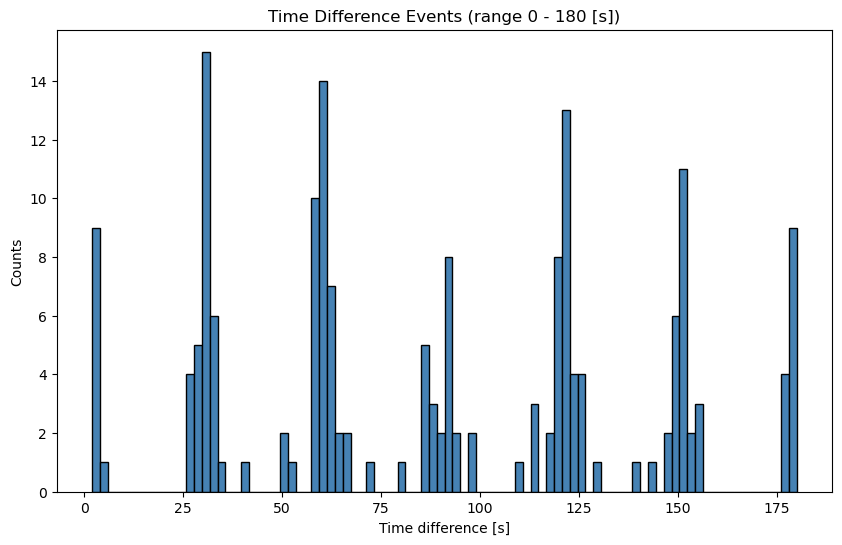

In [19]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

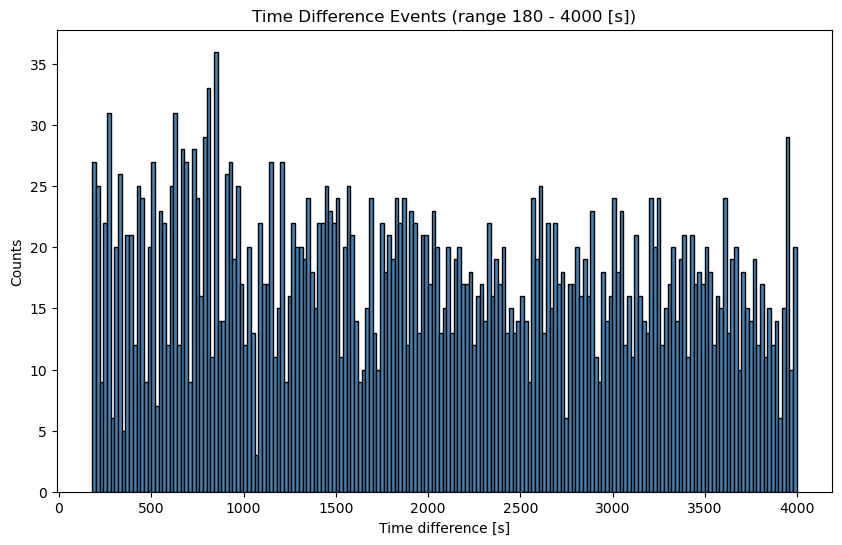

In [20]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=20)

# Data preparation

In [7]:
def CreateGrid(df, interval):

    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        if s in ["A5", "A9"] or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_avg(col(s)).alias(s)
        aggs.append(agg_func)

    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [8]:
%%time

interval = 60 #seconds

df_grid = CreateGrid(df_all_hw, interval)
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)

NameError: name 'df_all_hw' is not defined

In [9]:
print(f"Records (rows) are {df_grid.count()}.")

NameError: name 'df_grid' is not defined

In [10]:
def BuildBlocks(df, max_interval, sensors):    

    w_hw = Window.partitionBy("hwid").orderBy("when")
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df = df.drop("CheckNewBlock")

    return df

In [91]:
df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors)

In [92]:
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

[Stage 12:>                                                         (0 + 1) / 1]

+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|  hwid|BlockID|      when|       window_start|         window_end|S117|S118|S169|S170|  A5|  A9|ComError|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|SW-088|      0|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00| 0.0| 0.0|NULL|NULL|NULL|NULL|    NULL|
|SW-088|      0|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00| 0.0| 0.0| 0.0| 0.0|NULL|NULL|    NULL|
|SW-088|      0|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00| 0.0| 0.0| 0.0| 0.0|NULL|NULL|    NULL|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
only showing top 3 rows



In [93]:
for hw in list_hw:
    print(f"{hw} has {df_blocks.where(col("hwid") == hw).select('BlockID').distinct().count()} Blocks.")

SW-088 has 1047 Blocks.
SW-106 has 186 Blocks.
SW-065 has 101 Blocks.
SW-115 has 78 Blocks.


In [ ]:
#Fill most of all values inside the arbitraty time gap

def FillNull(df, sensors, max_gap=240):
    w = Window.partitionBy("hwid", "BlockID").orderBy("when")
    
    for s in sensors:
        prev_val = lag(col(s)).over(w)
        next_val = lead(col(s)).over(w)
        
        df = df.withColumn(s, when(col(s).isNotNull(), col(s))
            .when(
                (col("NextDiff") <= max_gap) & 
                (col("NextDiff") <= col("PrevDiff")), 
                next_val).when(col("PrevDiff") <= max_gap, prev_val))

    
    df = df.na.drop(subset=sensors)
    
    return df

In [ ]:
df_blocks = FillNull(df_blocks, sensors + engines, max_gap=240).persist()
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
#Saving the final DF:
save = False
if save:
    #Transoform each hwid into panda dataframe and then combine (no memory issue)
    all_chunks = []
    for hwid in df_blocks.select("hwid").distinct().collect():
        hwid_value = hwid['hwid']
        chunk = df_blocks.filter(f"hwid = '{hwid_value}'").toPandas()
        all_chunks.append(chunk)
        
    # Combine
    pandas_df = pd.concat(all_chunks, ignore_index=True)
    pandas_df.to_parquet("/mnt/shared/df_blocks.parquet", index=False)

# Import the file

In [11]:
df_blocks = spark.read.parquet("/mnt/shared/df_blocks.parquet/")

df_blocks = df_blocks.withColumn("A5", col("A5").cast("int"))
df_blocks = df_blocks.withColumn("A9", col("A9").cast("int"))

In [12]:
%%time

df_max = df_blocks.select(*sensors).groupBy().agg( *[spark_max(s).alias(s) for s in sensors] )
max_values = df_max.first().asDict()

df_min = df_blocks.select(*sensors).groupBy().agg( *[spark_min(s).alias(s) for s in sensors] )
min_values = df_min.first().asDict()

useless_sensors = [k for k in sensors if max_values[k] == min_values[k]]
useful_sensors = [k for k in sensors if k not in useless_sensors]

[Stage 4:===================================================>       (7 + 1) / 8]

CPU times: user 80.4 ms, sys: 72.1 ms, total: 153 ms
Wall time: 10.3 s


In [13]:
print(f"There are {len(useless_sensors)} useless sensors (just one value), which are:\n")
print(useless_sensors)
print("\n")
print(f"There are {len(useful_sensors)} useful sensors (at least 2 distinct values), which are:\n")
print(useful_sensors)

There are 28 useless sensors (just one value), which are:

['S106', 'S108', 'S11', 'S110', 'S15', 'S16', 'S163', 'S165', 'S167', 'S17', 'S175', 'S176', 'S19', 'S34', 'S42', 'S43', 'S45', 'S49', 'S50', 'S54', 'S56', 'S57', 'S63', 'S69', 'SA12', 'SA4', 'SA8', 'SW']


There are 102 useful sensors (at least 2 distinct values), which are:

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9'

In [14]:
df_blocks = df_blocks.drop(*useless_sensors)

In [15]:
list_hw = df_blocks.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw

['SW-088', 'SW-106', 'SW-065', 'SW-115']

--------------------------SW-088------------------------------
Longest blocks:

      BlockID  minutes
1038      460     2094
1039      483     2130
1040      164     2372


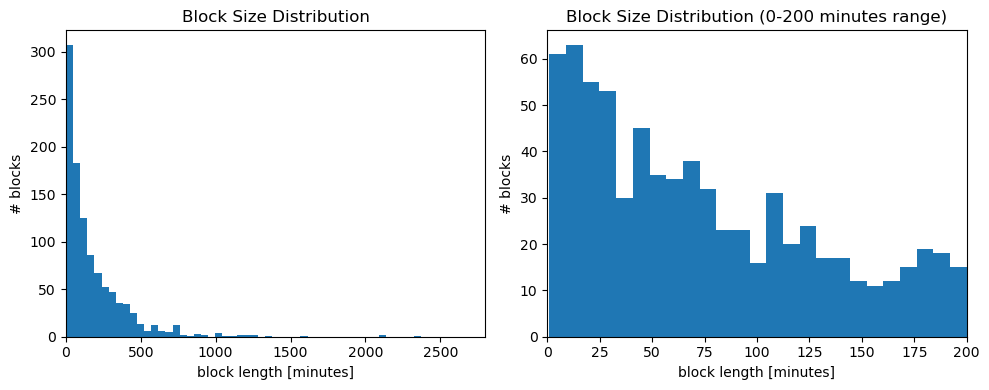

--------------------------SW-106------------------------------
Longest blocks:

     BlockID  minutes
182      180     3508
183      175     3961
184      182     4658


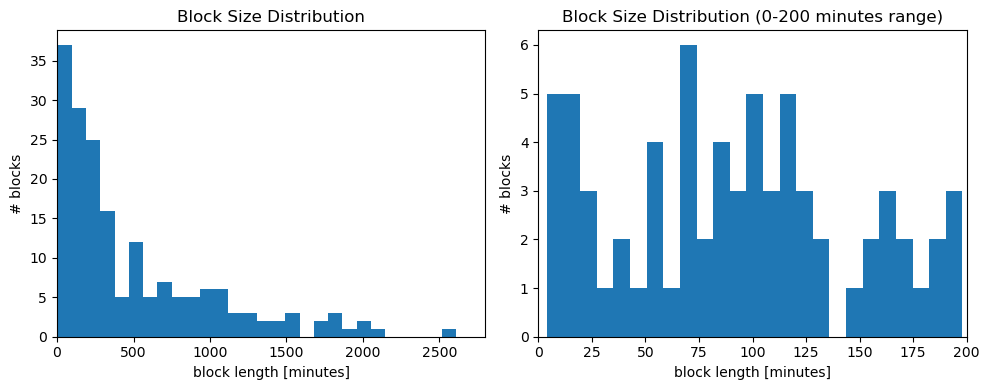

--------------------------SW-065------------------------------
Longest blocks:

     BlockID  minutes
98        40     5112
99        12     6200
100       15    12731


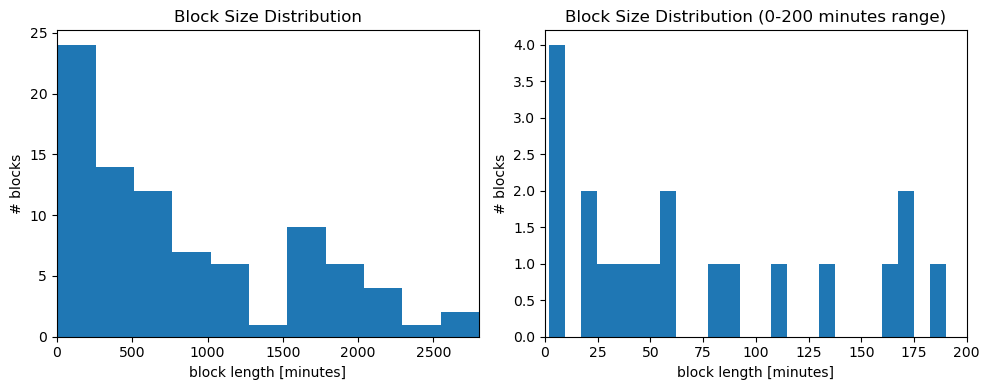

--------------------------SW-115------------------------------
Longest blocks:

    BlockID  minutes
75       73     8623
76       23    10973
77        8    14199


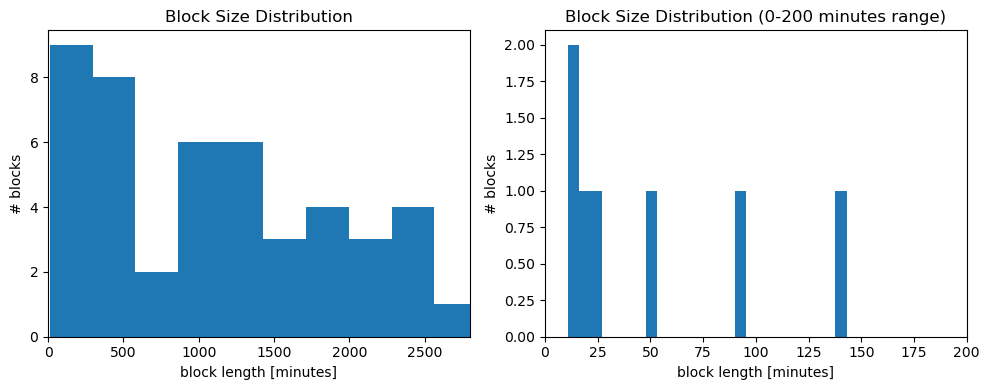

In [16]:
for hw in list_hw:


    print(f"--------------------------{hw}------------------------------")
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("minutes")).orderBy("minutes")
    data = dist_blocks.toPandas()
    print("Longest blocks:\n")
    print( data.tail(3) )
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['minutes'], bins=50)
    axes[0].set_xlim(0, 2800)
    axes[0].set_xlabel("block length [minutes]")
    axes[0].set_ylabel("# blocks")
    axes[0].set_title("Block Size Distribution")
    
    data_low_range = data[(data['minutes'] >= 0) & (data['minutes'] <= 200)]
    axes[1].hist(data_low_range['minutes'], bins=25)
    axes[1].set_xlim(0, 200)
    axes[1].set_xlabel("block length [minutes]")
    axes[1].set_ylabel("# blocks")
    axes[1].set_title("Block Size Distribution (0-200 minutes range)")
    plt.tight_layout()
    plt.show()

# Anomaly detection (1)

## Distributed Analysis for Anomaly Detection

In [17]:
def detect_anomalies(df, time_separator, threshold, sensors):
    '''
    Crea colonne con flag per anomalie.
    '''
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("when")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('when')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'when', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Quando ci sono delle righe comprese tra anomalie con stesso ID, queste righe sono a loro volta considerate anomalie
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    return df_flag \
        .select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [18]:
%%time

list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df = df_blocks.filter( col("hwid") == hw),
        time_separator = 60*40, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

list_df_anomalies

CPU times: user 138 ms, sys: 84.9 ms, total: 223 ms
Wall time: 5.12 s


{'SW-088': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-106': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-065': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-115': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int]}

In [19]:
hw_to_inspect = 'SW-088'

In [20]:
%%time

list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|71     |1602481950|1   |0   |1   |1   |true     |false    |true     |false    |1           |
|71     |1602482010|1   |0   |0   |1   |true     |false    |true     |false    |1           |
|71     |1602482070|0   |0   |0   |1   |true     |false    |true     |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 7.63 ms, sys: 8.06 ms, total: 15.7 ms
Wall time: 6.21 s


In [21]:
print("Know some BlockID where there are anomalies, so we can plot it and see.")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter('flag_S117').select('BlockID').distinct().orderBy('BlockID')
BlockWithAnom.show(3, truncate=False)

listBlockAnom = BlockWithAnom.collect()

Know some BlockID where there are anomalies, so we can plot it and see.


+-------+
|BlockID|
+-------+
|71     |
|90     |
|136    |
+-------+
only showing top 3 rows



In [26]:
def inspect_anomalies_old(df, sensor, blockID):

    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    t = range(len(anomalies))

    plt.bar(t, values, width = 1, alpha = 0.5, edgecolor=None, lw=1)
    plt.bar(t, anomalies, width= 1, alpha = 0.5, label="anomal")
    plt.xlabel("Consecutive available data")
    plt.ylabel(sensor)
    plt.legend(loc='lower right')
    plt.title(f"Block N.{blockID}")
    plt.legend()
    plt.show()

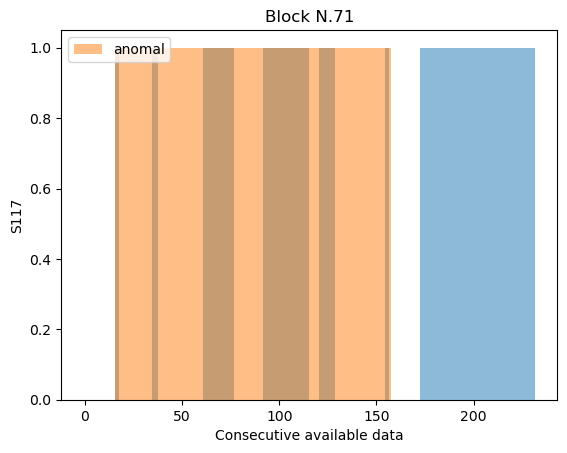

In [27]:
inspect_anomalies_old(list_df_anomalies[hw_to_inspect], 'S117', listBlockAnom[0][0])

In [28]:
def inspect_anomalies(df, sensor, blockID):
    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    def extract_when(df):
        return df.filter(col('BlockID') == blockID) \
            .select('when') \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    whens     = extract_when(df)

    if not whens:
        print(f"Nessun dato per BlockID={blockID}")
        return

    # Costruisci asse temporale continuo (secondi, passo 60)
    t_min = min(whens)
    t_max = max(whens)
    full_t = list(range(t_min, t_max + 60, 60))  

    # Normalizza asse x a partire da 0 (in minuti)
    full_t_rel = [(t - t_min) // 60 for t in full_t]
    whens_rel  = [(w - t_min) // 60 for w in whens]

    # Mappa tempi -> valori/anomalie
    values_map    = dict(zip(whens_rel, values))
    anomalies_map = dict(zip(whens_rel, anomalies))

    aligned_values    = [values_map.get(t, 0) for t in full_t_rel]
    aligned_anomalies = [anomalies_map.get(t, 0) for t in full_t_rel]

    # Missing: dove non c’è un dato registrato
    missing = [1 if t not in whens_rel else 0 for t in full_t_rel]

    # Plot con colori espliciti
    plt.bar(full_t_rel, aligned_anomalies, width=1, alpha=0.5, color="orange", label="anomal")
    plt.bar(full_t_rel, aligned_values, width=1, alpha=0.5, color="blue",   label=sensor)
    plt.bar(full_t_rel, missing, width=1, alpha=0.1, color="red",   label="missing")

    plt.xlabel("Minutes (relative to block start)")
    plt.ylabel(sensor)
    plt.legend(loc='lower right')
    plt.title(f"Block N.{blockID}")
    plt.show()

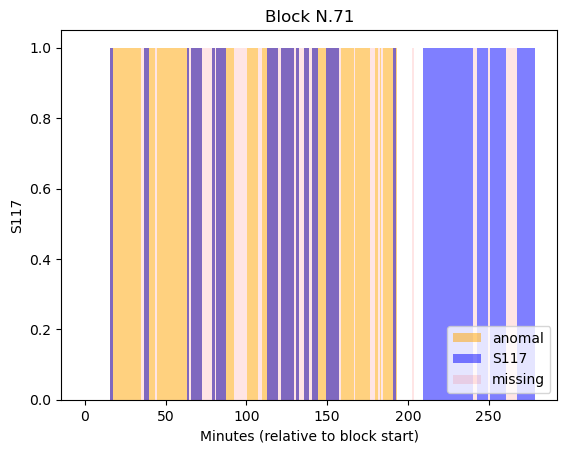

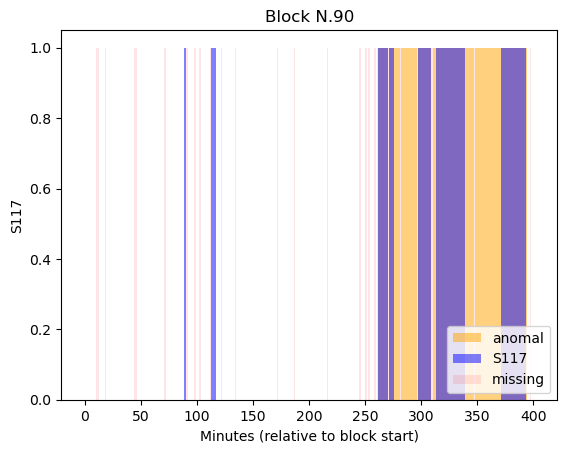

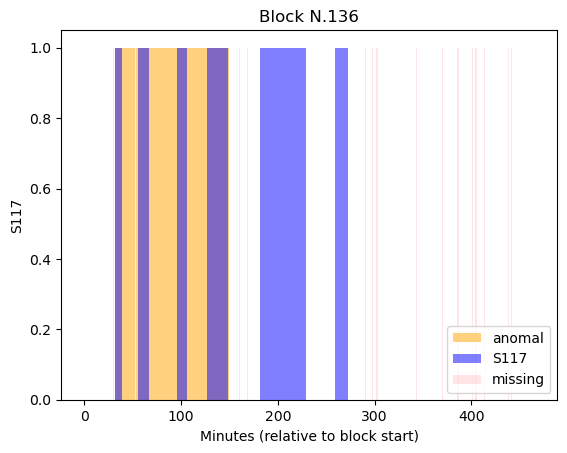

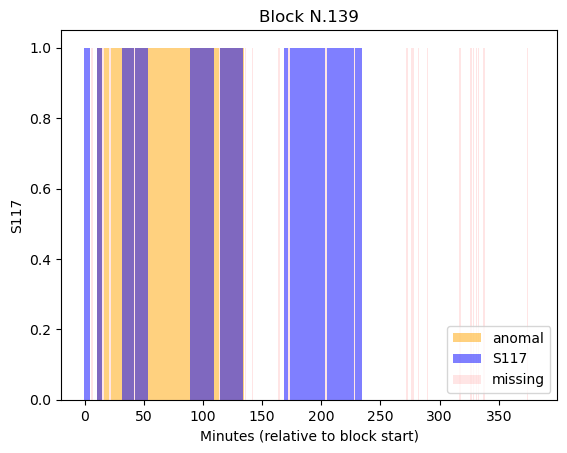

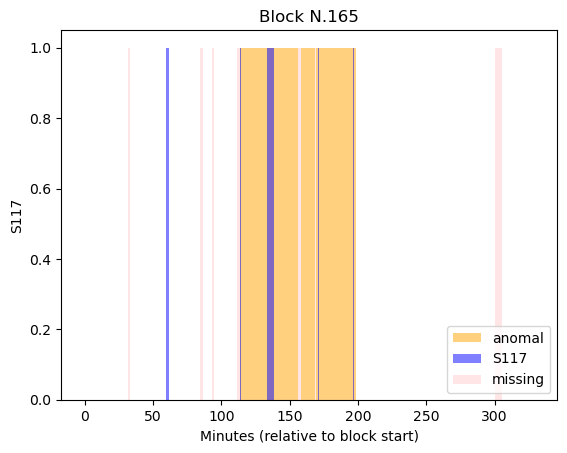

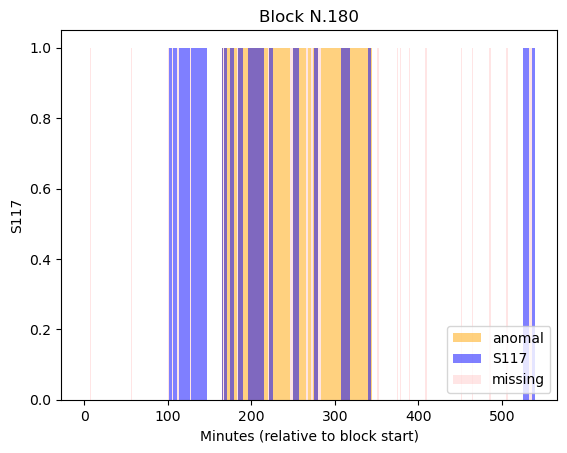

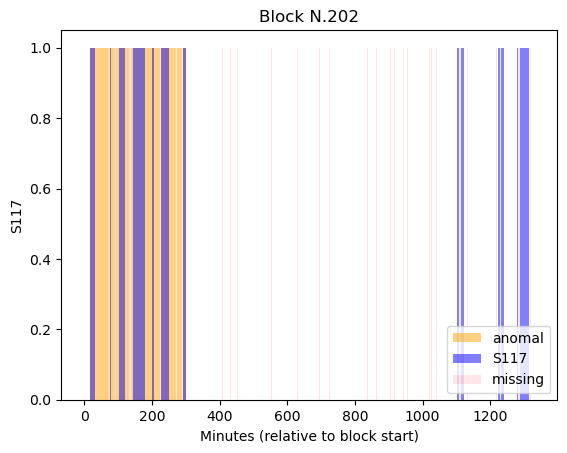

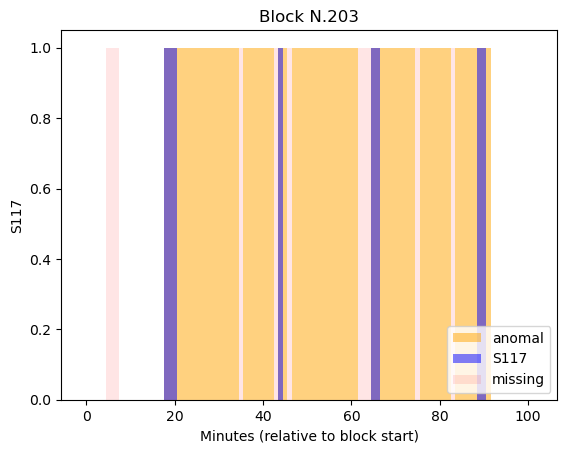

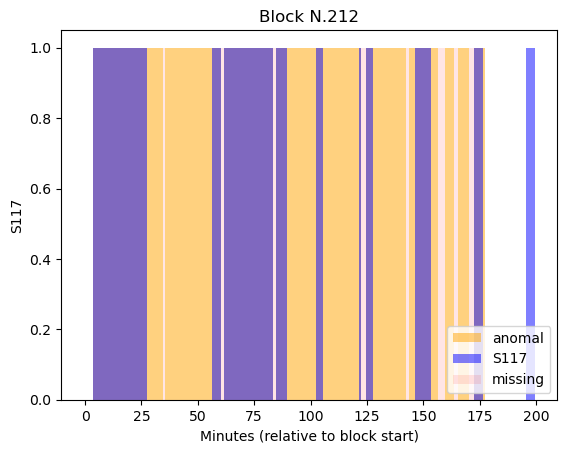

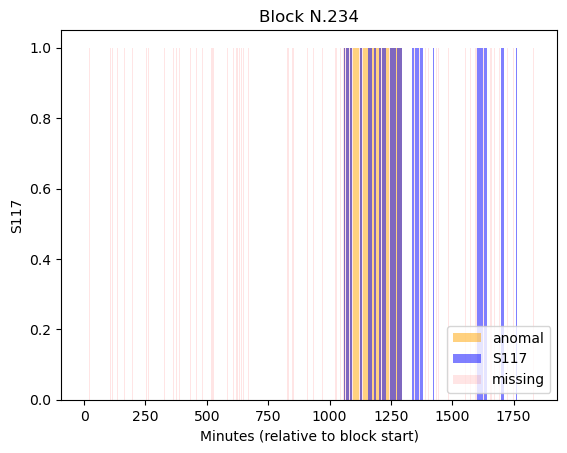

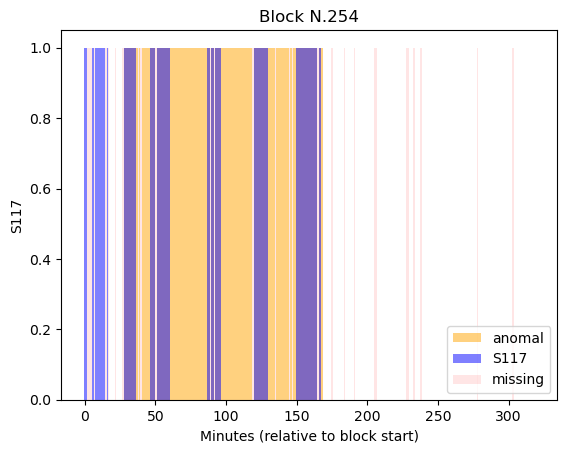

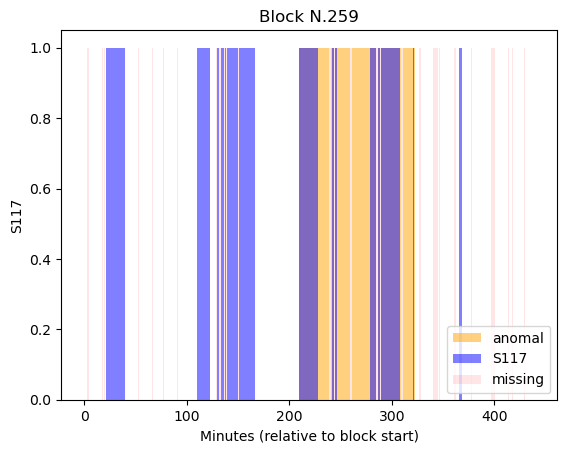

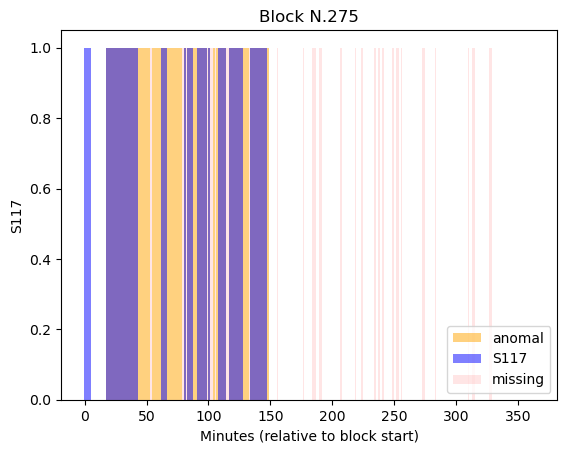

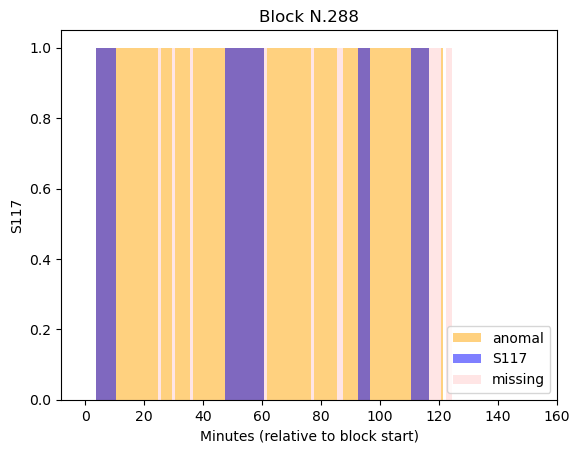

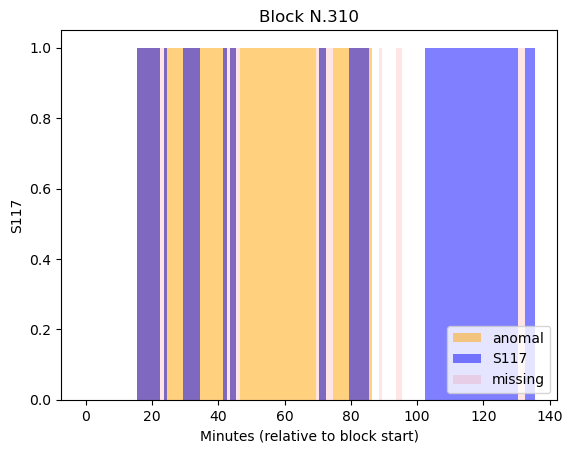

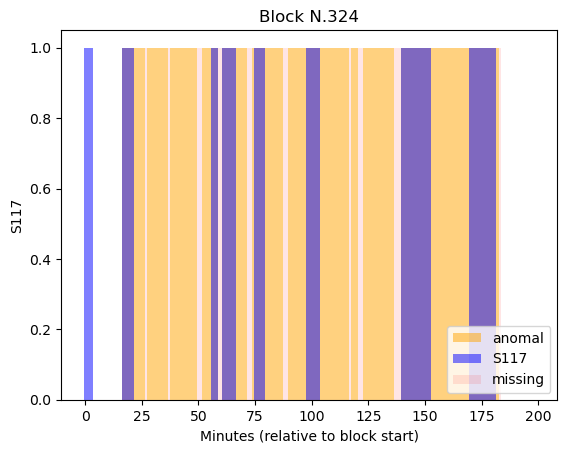

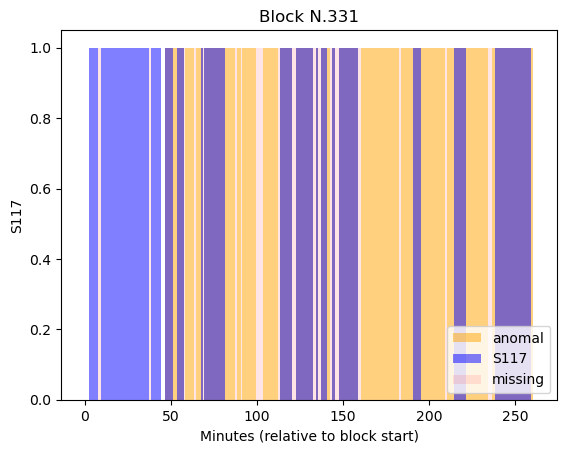

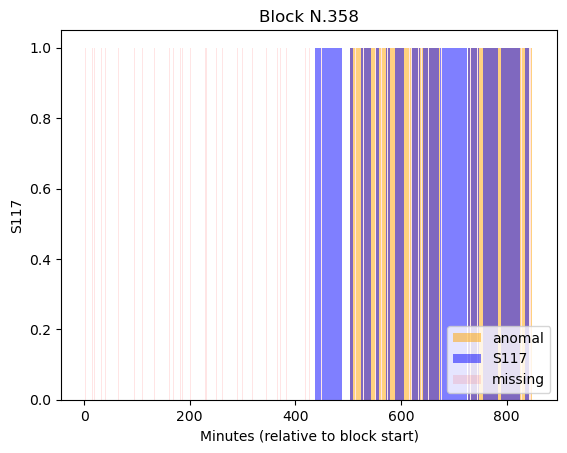

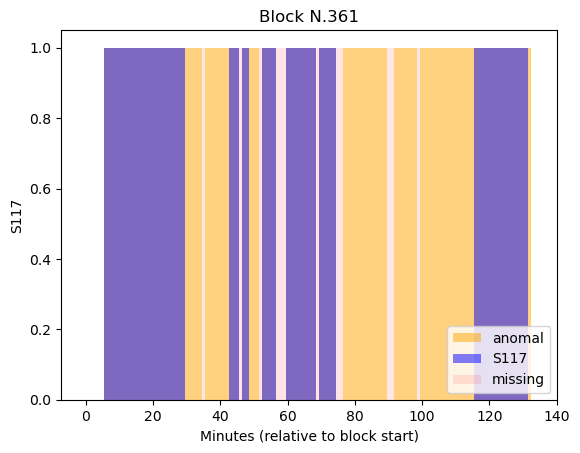

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [29]:
for row in listBlockAnom:
    inspect_anomalies(list_df_anomalies[hw_to_inspect], 'S117', row[0])

In [30]:
df_blocks.where( (col("BlockID")==71) & (col("hwid")==hw_to_inspect)) \
    .select("window_start","window_end","NextDiff",'S117') \
    .withColumn("NumeroRiga", monotonically_increasing_id()).show(250)

+-------------------+-------------------+--------+----+-----------+
|       window_start|         window_end|NextDiff|S117| NumeroRiga|
+-------------------+-------------------+--------+----+-----------+
|2020-10-12 05:36:00|2020-10-12 05:37:00|    60.0|   0|25769803776|
|2020-10-12 05:37:00|2020-10-12 05:38:00|    60.0|   0|25769803777|
|2020-10-12 05:38:00|2020-10-12 05:39:00|    60.0|   0|25769803778|
|2020-10-12 05:39:00|2020-10-12 05:40:00|    60.0|   0|25769803779|
|2020-10-12 05:40:00|2020-10-12 05:41:00|    60.0|   0|25769803780|
|2020-10-12 05:41:00|2020-10-12 05:42:00|    60.0|   0|25769803781|
|2020-10-12 05:42:00|2020-10-12 05:43:00|    60.0|   0|25769803782|
|2020-10-12 05:43:00|2020-10-12 05:44:00|    60.0|   0|25769803783|
|2020-10-12 05:44:00|2020-10-12 05:45:00|    60.0|   0|25769803784|
|2020-10-12 05:45:00|2020-10-12 05:46:00|    60.0|   0|25769803785|
|2020-10-12 05:46:00|2020-10-12 05:47:00|    60.0|   0|25769803786|
|2020-10-12 05:47:00|2020-10-12 05:48:00|    60.

In [31]:
# Join on `when` and take just `flag_anomaly`

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    # df_anom = spark.createDataFrame(df_anom.rdd, df_anom.schema)  # Break lineage
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )
    #df_blocks_anom = df_blocks_anom.persist()

list_df_blocks_anom[hw_to_inspect].printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- window_start: timestamp_ntz (nullable = true)
 |-- window_end: timestamp_ntz (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: double (nullable = true)
 |-- P1: double (nullable = true)
 |-- P10: double (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: double (nullable = true)
 |-- P17: double (nullable = true)
 |-- P18: double (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: double (nullable = true)
 |-- P6: double (nullable = true)
 |-- P7: double (nullable = true)
 |-- P8: double (nullable = true)
 |-- P9: double (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: double (nullable = true)
 |-- S100: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- S102: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S109: double (nullable = true)
 |-- S112: integer (nullable = true)
 |-- S113: in

## Linear correlation setup (used for anomalies, S125-S181, A5-A9)

In [97]:
def correlations(df, sensors_list, target_col, batch_size=25):
    """
    Compute correlations between sensors and target column in batches.
    Returns sorted DataFrame by absolute correlation (descending).
    """   
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [98]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df, hw):
    import matplotlib.pyplot as plt
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{hw} - {feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

## Correlation Analysis for Anomalies

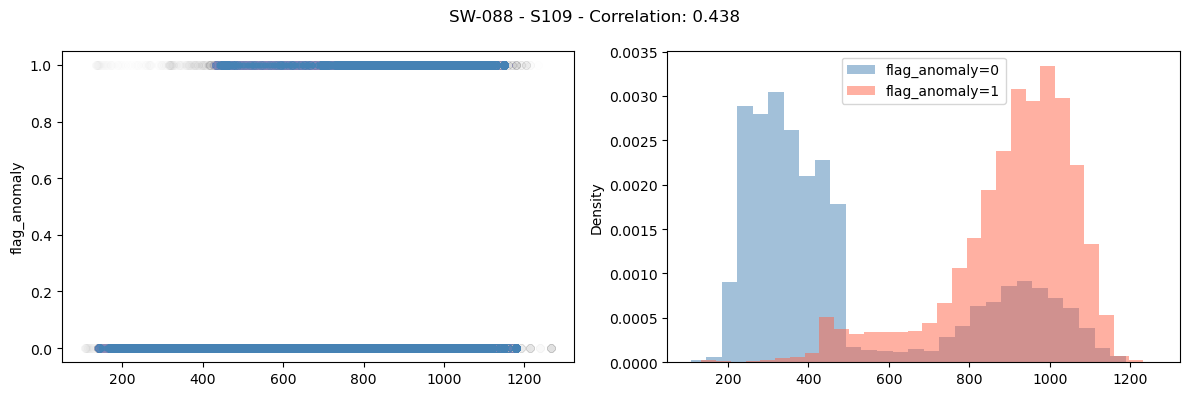

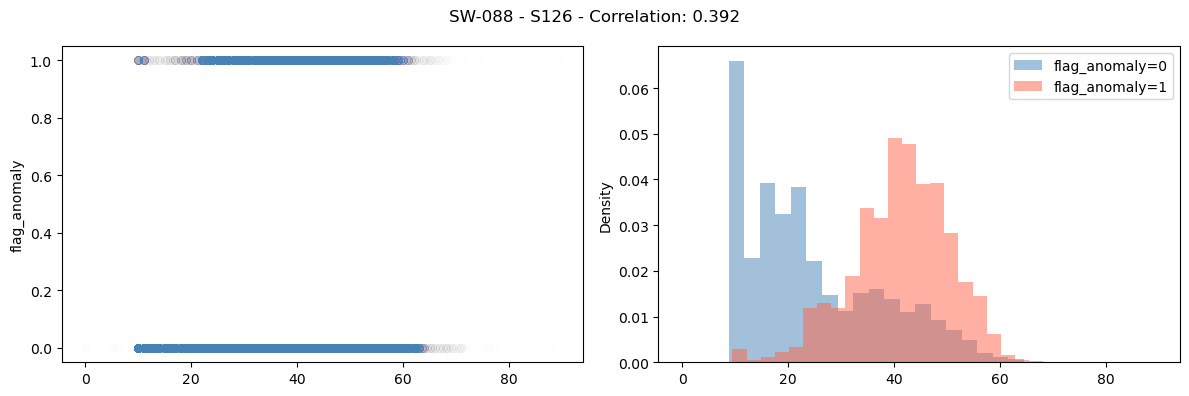

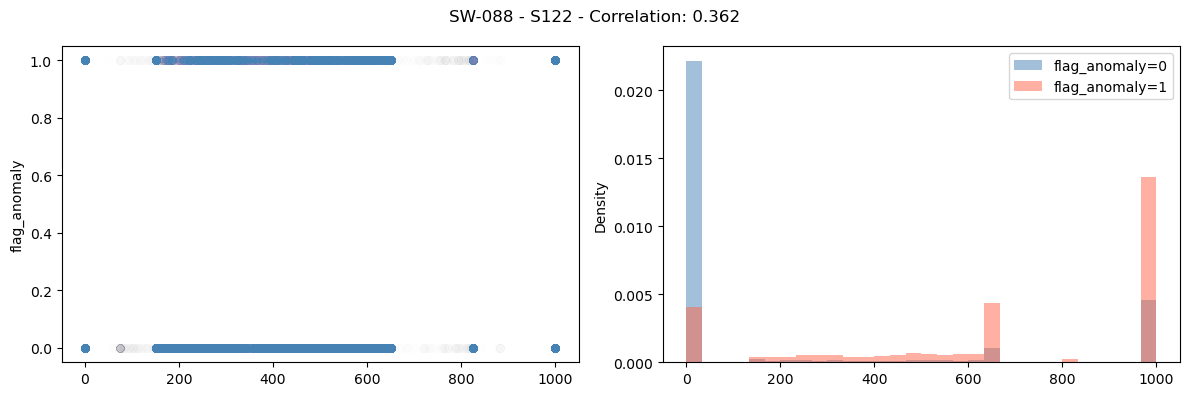

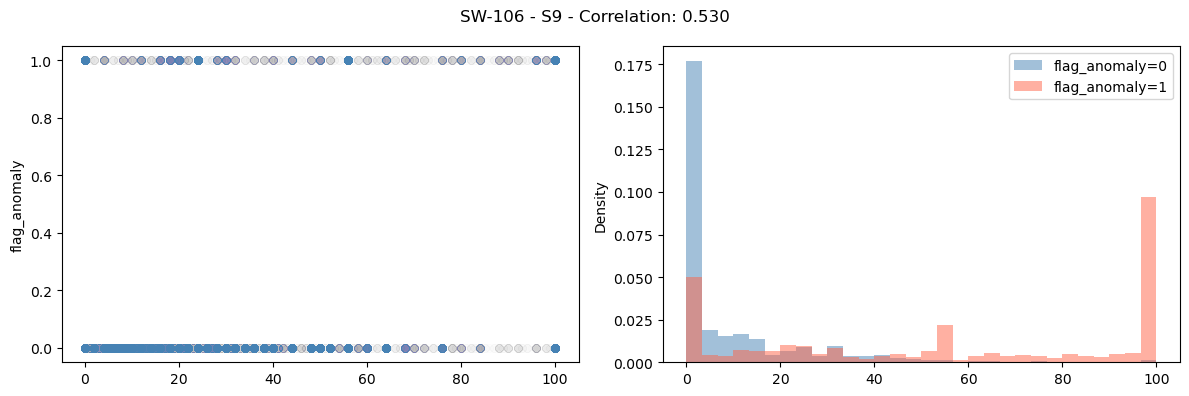

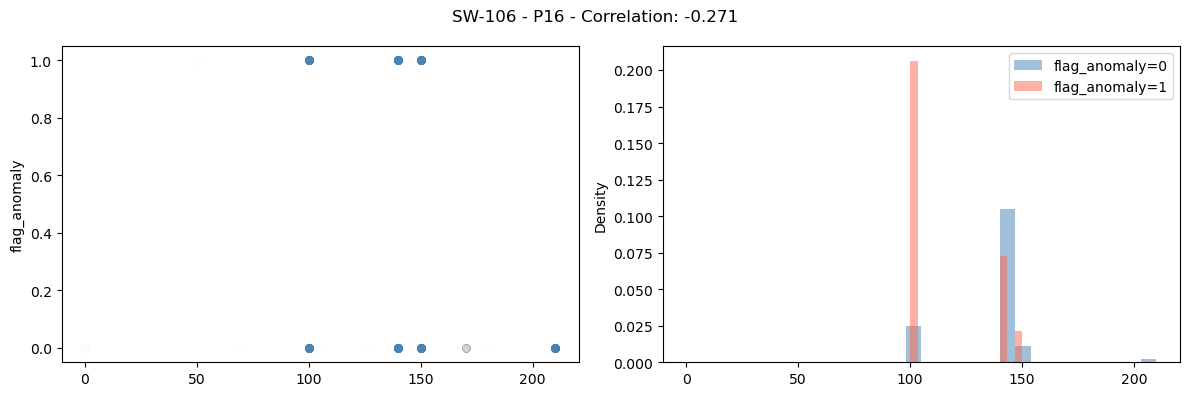

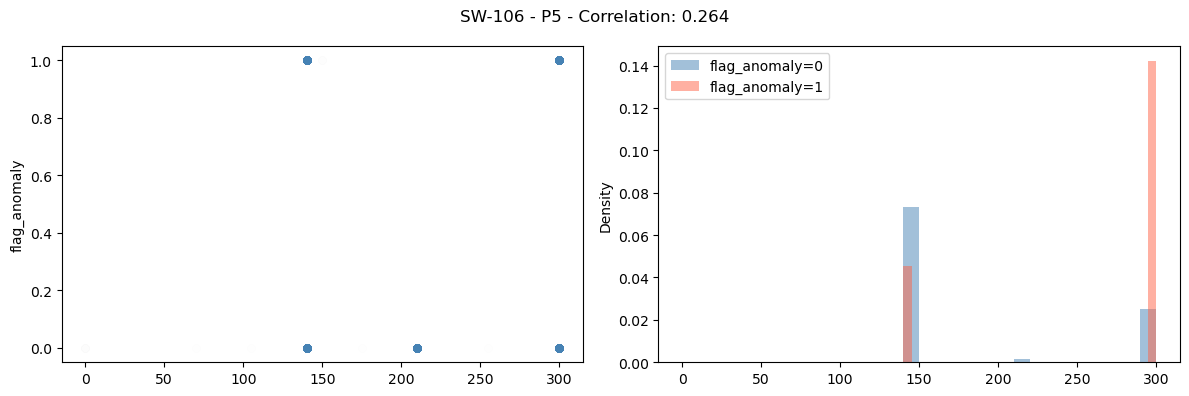

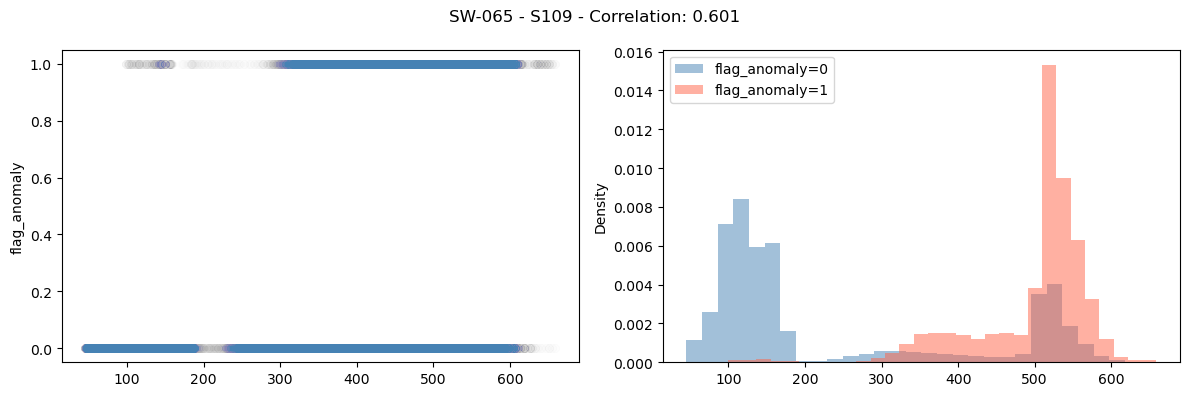

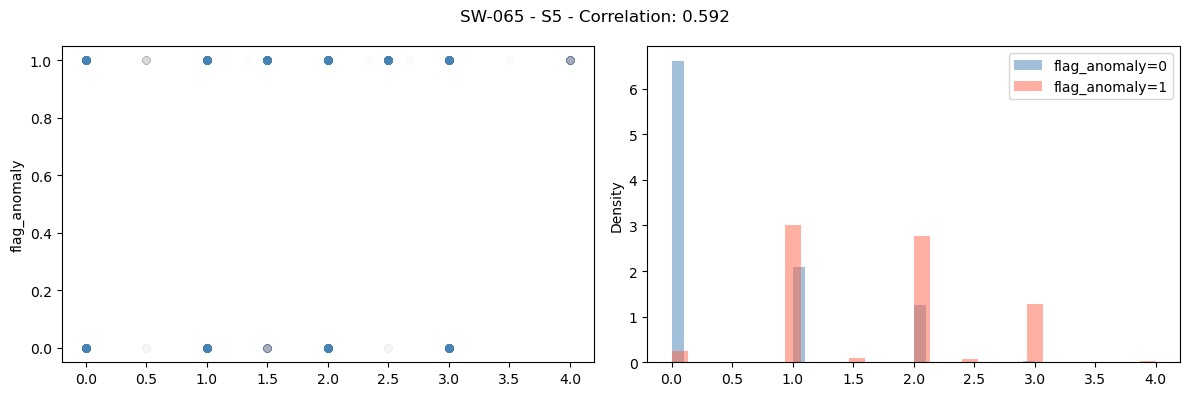

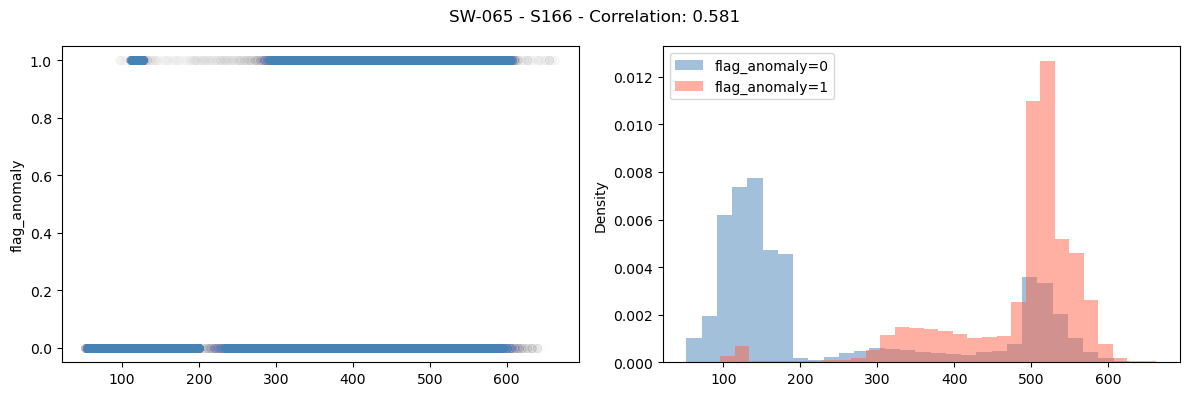

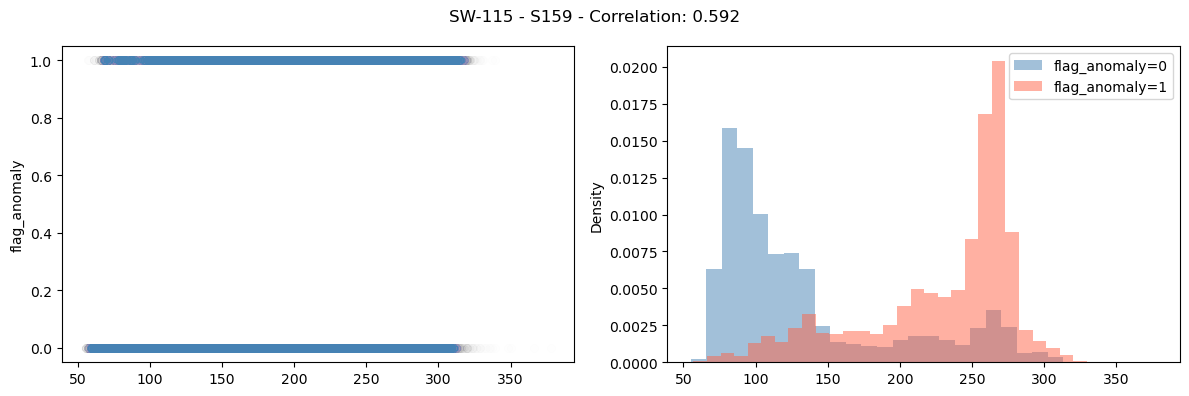

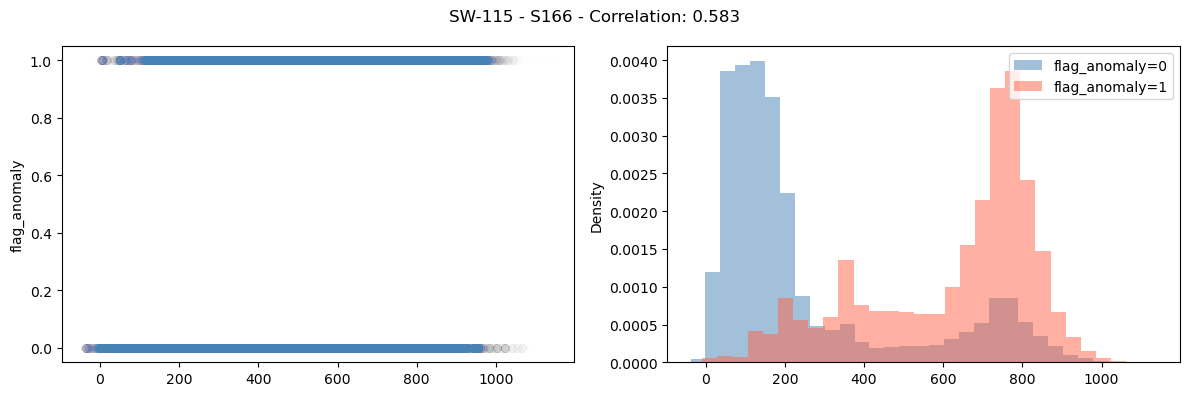

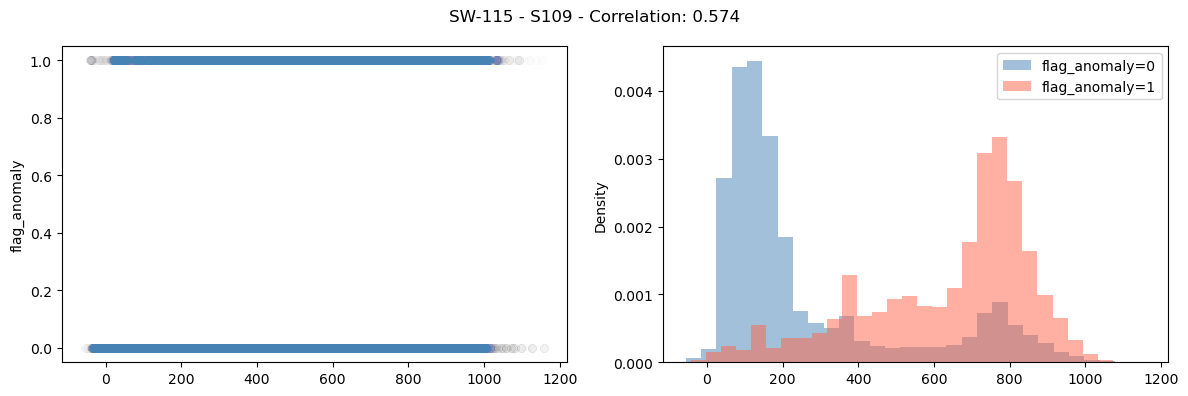

CPU times: user 4.4 s, sys: 199 ms, total: 4.6 s
Wall time: 2min 9s


In [31]:
%%time

for hw in list_hw:

    anomaly_corr = correlations(list_df_blocks_anom[hw], useful_sensors, 'flag_anomaly')
    
    # top_anom_corr = anomaly_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
    top_anom_corr = anomaly_corr.head(3)['Sensors'].tolist()

    display(HTML(f"<p style='font-size:24px; font-weight:bold;'>--------------------------------{hw}--------------------------------</p>"))
    plot_correlations(list_df_blocks_anom[hw], 'flag_anomaly', top_anom_corr, anomaly_corr, hw)
    
    # print(top_anom_corr)

## Alternative approach: Random Forest 

In [36]:
#Model the training set balancing the flag anomalies ratio
hw = 'SW-088'

df_final_flag0 = list_df_blocks_anom[hw].filter(col('flag_anomaly')==0)
df_final_flag1 = list_df_blocks_anom[hw].filter(col('flag_anomaly')==1)

to_drop_df = df_final_flag0.sample(withReplacement = False, fraction = 0.85, seed = 2503)

df_final_flag0_reduced = df_final_flag0.subtract(to_drop_df)

df_final_balanced = df_final_flag1.union(df_final_flag0_reduced)


#Check for the ratio between the flag anomalies 1 and 0
flag_ratio = df_final_balanced.filter(col('flag_anomaly')==1).count()/df_final_balanced.filter(col('flag_anomaly')==0).count()

print("Ratio [1/0]:",flag_ratio)

[Stage 1764:==============================================>         (5 + 1) / 6]

Ratio [1/0]: 0.9049526727151329


In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

def run_random_forest(df, feature_cols, label_col="label", n_trees=100, max_depth=5, test_fraction=0.2, seed = 2503):
    
    train_df, test_df = df.randomSplit([1 - test_fraction, test_fraction], seed=seed)
    print(f"Training on {train_df.count()} rows, testing on {test_df.count()} rows")
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=n_trees, maxDepth=max_depth,  seed=seed)

    pipeline = Pipeline(stages=[assembler, rf]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train_df) 

    train_predictions = model.transform(train_df)
    test_predictions = model.transform(test_df)

    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"RandomForest trained with {n_trees} trees, maxDepth={max_depth}")
    print(f"Test Accuracy = {test_accuracy:.4f}")

    rf_model = model.stages[-1] 
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])

    print("\nFeature Importances:")
    for col, imp in feature_importance:
        print(f"{col}: {imp:.4f}")

    return model, train_predictions, test_predictions, test_accuracy

In [39]:
%%time

vector_to_drop = ['A5', 'A9', 'ComError', 'overheating']

sensors_forest = [s for s in useful_sensors if s not in vector_to_drop]

model, train_preds, test_preds, test_accuracy = run_random_forest(df_final_balanced, feature_cols=sensors_forest, label_col="flag_anomaly", n_trees = 120, max_depth = 10, test_fraction=0.33333)

test_preds.select('flag_anomaly', 'prediction', 'probability').show(10, truncate = 0)

Training on 32373 rows, testing on 16129 rows


25/08/21 17:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1225.4 KiB
25/08/21 17:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1767.8 KiB
25/08/21 17:13:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/08/21 17:13:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/08/21 17:13:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/08/21 17:13:32 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
25/08/21 17:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1243.3 KiB
25/08/21 17:14:02 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
                                                                                

RandomForest trained with 120 trees, maxDepth=10
Test Accuracy = 0.8996

Feature Importances:
S109: 0.1240
S5: 0.0934
S125: 0.0667
S73: 0.0571
S102: 0.0542
S126: 0.0479
S122: 0.0461
S81: 0.0417
S107: 0.0385
S9: 0.0326
S101: 0.0284
S124: 0.0211
S166: 0.0172
S83: 0.0161
S164: 0.0158
S97: 0.0156
S90: 0.0147
S100: 0.0146
S70: 0.0134
S118: 0.0130
S40: 0.0113
S39: 0.0113
S158: 0.0108
S41: 0.0107
S47: 0.0102
S46: 0.0094
S138: 0.0090
S10: 0.0090
S157: 0.0087
S130: 0.0084
S3: 0.0072
S159: 0.0071
S80: 0.0070
S140: 0.0065
S72: 0.0064
S203: 0.0064
S86: 0.0064
S154: 0.0062
S178: 0.0061
S71: 0.0060
S123: 0.0056
S180: 0.0056
S181: 0.0035
S129: 0.0034
S117: 0.0033
S137: 0.0031
S147: 0.0031
S37: 0.0030
S202: 0.0027
S128: 0.0026
S143: 0.0025
SA11: 0.0022
S114: 0.0019
SA9: 0.0019
S6: 0.0019
S179: 0.0014
P10: 0.0013
S170: 0.0013
S205: 0.0011
S169: 0.0011
P16: 0.0011
S53: 0.0009
S112: 0.0009
S206: 0.0009
S94: 0.0007
S7: 0.0007
S173: 0.0006
S172: 0.0006
S201: 0.0005
S151: 0.0005
S1: 0.0005
S171: 0.0004
S127

25/08/21 17:14:14 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
25/08/21 17:14:14 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


+------------+----------+----------------------------------------+
|flag_anomaly|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |0.0       |[0.7553949586127506,0.2446050413872493] |
|1           |0.0       |[0.5906355423169716,0.40936445768302854]|
|1           |0.0       |[0.5603523724739267,0.4396476275260734] |
|1           |1.0       |[0.3011140817820693,0.6988859182179308] |
|1           |1.0       |[0.404057790682642,0.5959422093173579]  |
|1           |1.0       |[0.19532519198876985,0.8046748080112301]|
|1           |1.0       |[0.14804283629707024,0.8519571637029297]|
|1           |1.0       |[0.16982303671128296,0.830176963288717] |
|1           |1.0       |[0.2456904006859635,0.7543095993140365] |
|1           |1.0       |[0.44289926506583166,0.5571007349341683]|
+------------+----------+----------------------------------------+
only showing top 10 rows

CPU times: user 132 ms, sys: 43.3 ms

In [42]:
#Prediction with the obtained model
n = 8
data_row = df_final_balanced.orderBy(rand()).limit(n)

predicted_data = model.transform(data_row)
predicted_data.select("S109", "S166", "S102", "flag_anomaly", "prediction").show()

25/08/21 17:16:31 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
                                                                                

+------+-----+-----+------------+----------+
|  S109| S166| S102|flag_anomaly|prediction|
+------+-----+-----+------------+----------+
|1094.0|125.0|335.5|           1|       1.0|
| 488.0|235.0|293.0|           0|       0.0|
| 828.5|118.0|220.0|           1|       1.0|
| 335.0|273.0|179.0|           0|       0.0|
| 490.0|208.0|219.5|           1|       1.0|
| 576.0|666.0|196.0|           1|       1.0|
|1111.0|180.0|342.0|           1|       1.0|
| 945.0|869.0|295.5|           1|       1.0|
+------+-----+-----+------------+----------+



## Alternative approach: PCA

In [40]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

def covariance_matrix(df, cols=None):
    """
    This function returns the covariance matrix from the df
    """
    
    if cols is None:
        cols = df.columns

    for c in cols:
        df = df.withColumn(c, col(c).cast(DoubleType()))
    
    means = df.select([mean(c).alias(c) for c in cols]).collect()[0].asDict()
    
    df_centered = df.select(*[(col(c) - means[c]).alias(c) for c in cols])
    
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    df_centered_vec = assembler.transform(df_centered).select("features")
    
    n = df.count()
    cov_matrix = (
        df_centered_vec.rdd
        .map(lambda row: row.features.toArray())
        .map(lambda x: np.outer(x, x))
        .reduce(lambda a, b: a + b) / (n - 1)
    )
    
    return cov_matrix, cols

In [41]:
pca_sensors = [ 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10','S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
for hw in [hw_to_inspect]: # mettici list_hw per averlo generale   
    df_anomalies_n = list_df_blocks_anom[hw].select(pca_sensors)
    df_anomalies_n = df_anomalies_n.na.drop()

    cov_matrix, columns = covariance_matrix(df_anomalies_n)

    print("Columns:", columns)
    print("Covariance matrix:\n", cov_matrix)    
    #df_anomalies_n.printSchema()
    #df_anomalies_n.show(5)

[Stage 1962:==========================================>             (3 + 1) / 4]

Columns: ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
Covariance matrix:
 [[1.10804046e-01 6.21838345e-01 0.00000000e+00 ... 3.843

# Anomaly Detection (2)

## Correlation between device load and external temperature (S125-S181 vs S41) (Attualmente not working)

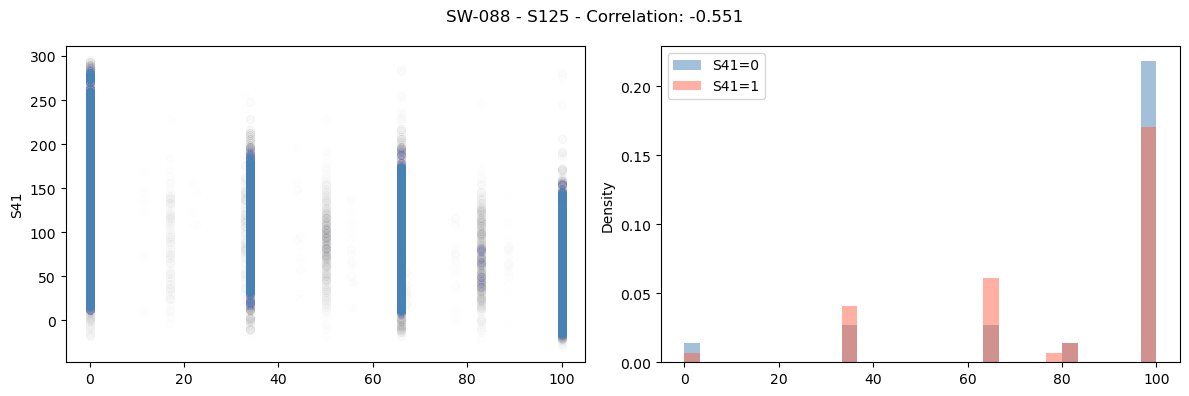

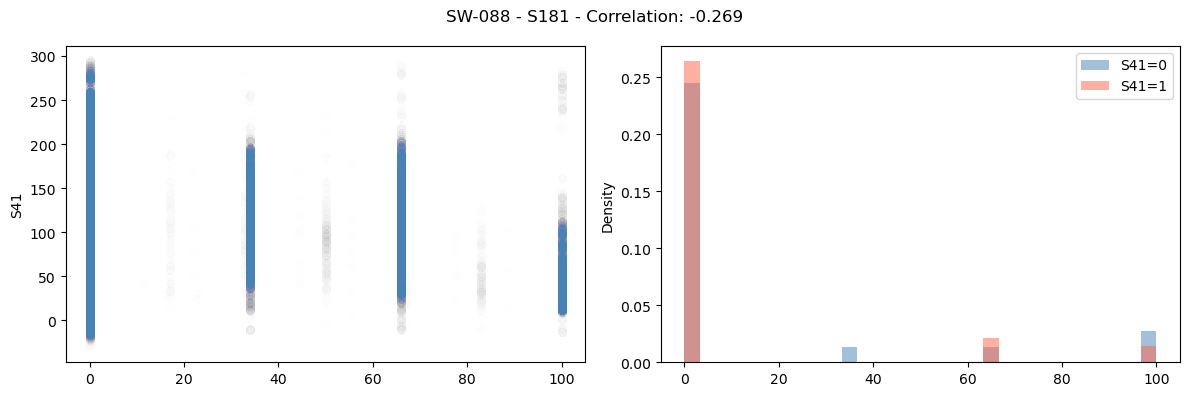

CPU times: user 722 ms, sys: 18.8 ms, total: 741 ms
Wall time: 7.62 s


In [101]:
%%time

load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

for hw in [hw_to_inspect]: # Sostituire hw_to_inspect con list_hw
    temper_corr = correlations(list_df_blocks_anom[hw], load_sensors, temperature_sensor)

    plot_correlations(list_df_blocks_anom[hw], temperature_sensor, load_sensors, temper_corr, hw)
    
    # print(top_anom_corr)

In [36]:
list_df_blocks_anom[hw_to_inspect].select('S41').show(10)

# Well well this is a problem, non è binario

+-----+
|  S41|
+-----+
|177.0|
|176.0|
|179.0|
|179.0|
|179.0|
|180.0|
|176.0|
|176.0|
|178.0|
|177.0|
+-----+
only showing top 10 rows



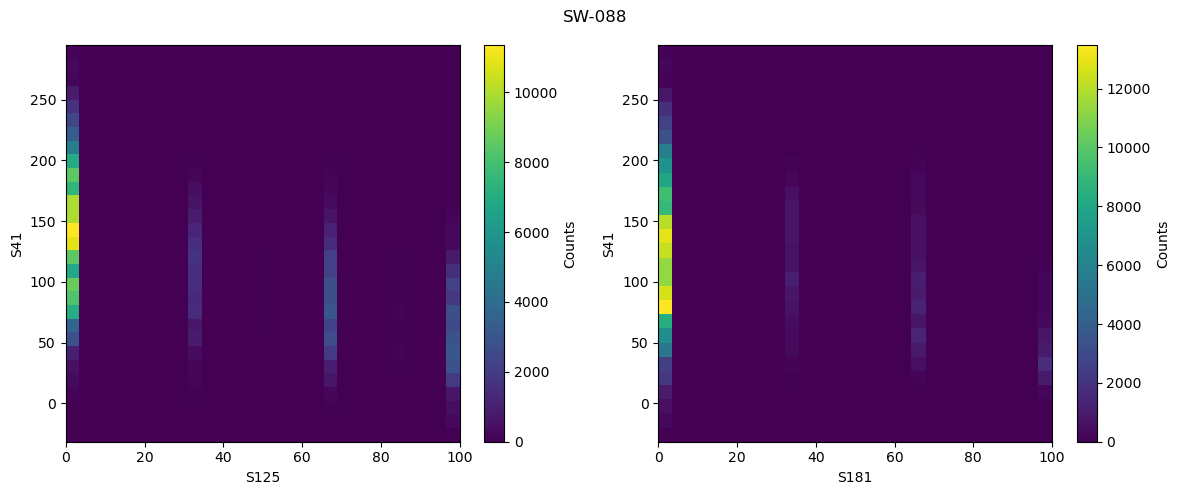

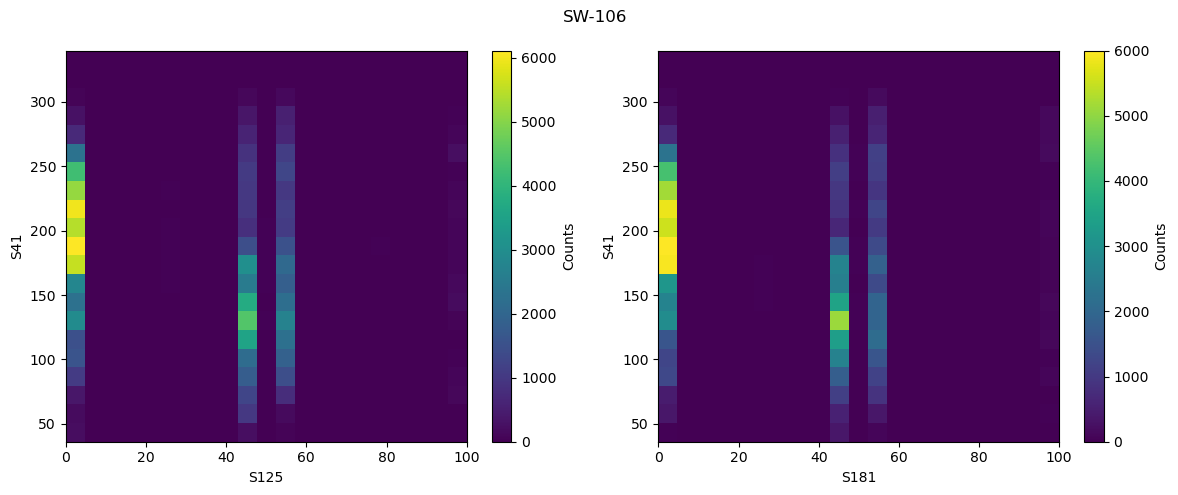

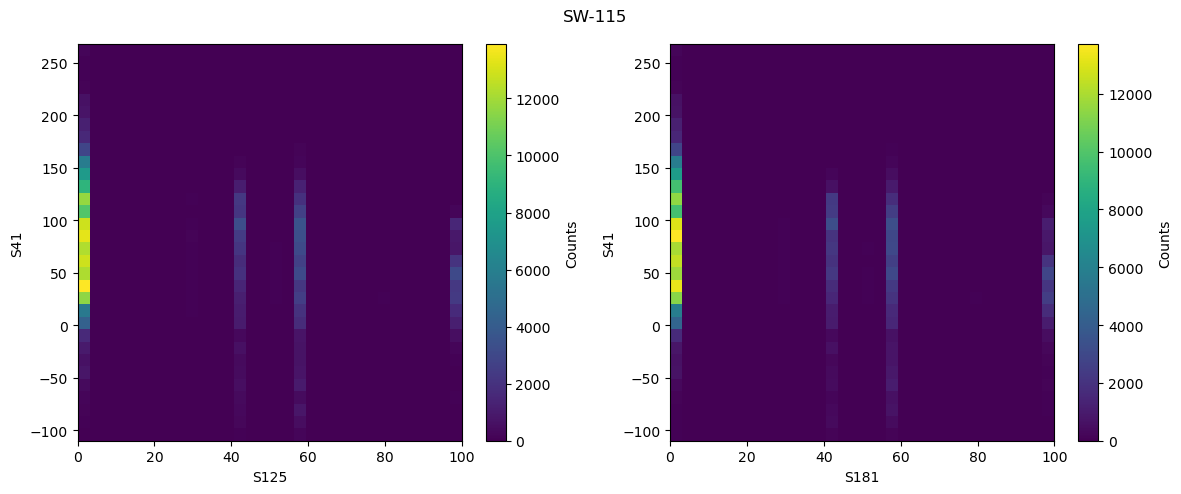

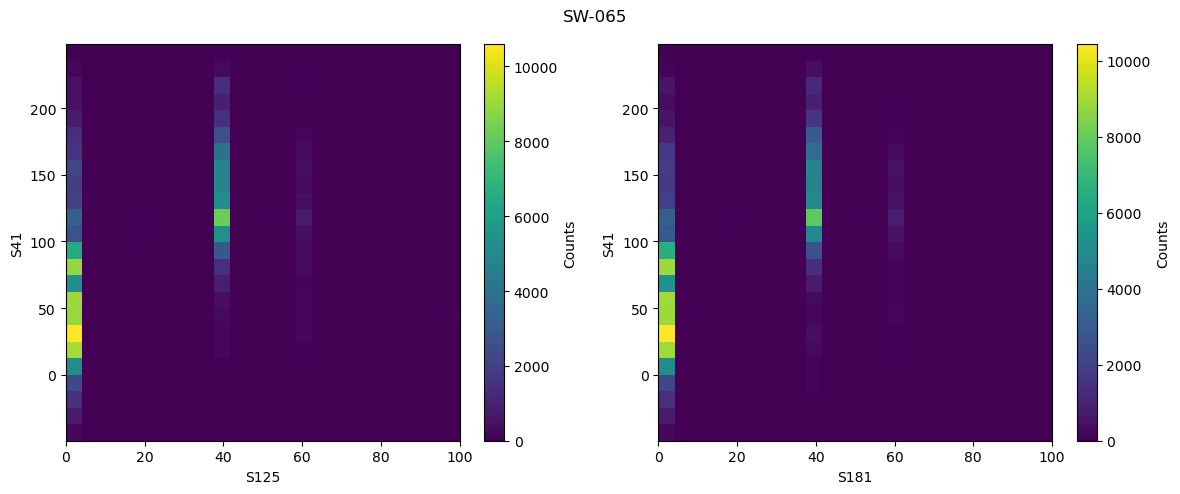

In [29]:
load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

# Inspect joint distribution of S41 and device load

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # fig.subplots_adjust(wspace=0.4)
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        filtered_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))
        
        temperature = filtered_df.select(temperature_sensor).rdd.flatMap(lambda x: x).collect()
        load        = filtered_df.select(load_sensor).rdd.flatMap(lambda x: x).collect()
        bins = int(np.sqrt(len(temperature))/15)
        
        counts, xedges, yedges, im = ax[i].hist2d(load, temperature, bins=bins)
        cbar = fig.colorbar(im, ax=ax[i])   
        cbar.set_label('Counts')  
        ax[i].set_ylabel(temperature_sensor)
        ax[i].set_xlabel(load_sensor)
        
    plt.tight_layout()    
    plt.show()

# Predictive maintenance

## Conversion of Alarms (A5, A9)

In [102]:
def extract_alarms(df, columns=["A5", "A9"], bits=[6, 7, 8]):
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )
    
    all_bit_cols = [col(f"{bit}-{col_name}") for col_name in columns for bit in bits]
    
    # condition ad least one alarm to get overheating
    condition = sum(all_bit_cols) > 0 # already menaged NULL, it gives 0
    df = df.withColumn("overheating", when(condition, 1).otherwise(0).cast("int"))
 
    return df

In [103]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms(df_grid.filter( col("hwid") == hw).select("when","A5","A9"),
                            columns=["A5", "A9"],
                            bits=[6, 7, 8] )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum("overheating")).collect()[0][0]} overheating signals." )

#list_df_alarms['SW-088'].show(3)
#list_df_alarms['SW-088'].where( (col("A5").isNotNull()) | (col("A9").isNotNull()) ).show(3)
list_df_alarms['SW-088'].where( col("overheating") == 1 ).show(3)

For hardware SW-088 were recorded 66 overheating signals.
For hardware SW-106 were recorded 0 overheating signals.
For hardware SW-065 were recorded 0 overheating signals.
For hardware SW-115 were recorded 0 overheating signals.
+----------+-----+---+----+----+----+----+----+----+-----------+
|      when|   A5| A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+-----+---+----+----+----+----+----+----+-----------+
|1601510790|18496|  0|   0|   1|   0|   0|   0|   0|          1|
|1601597190|18496|  0|   0|   1|   0|   0|   0|   0|          1|
|1601686290|18496|  0|   0|   1|   0|   0|   0|   0|          1|
+----------+-----+---+----+----+----+----+----+----+-----------+
only showing top 3 rows



In [104]:
%%time

list_df_final = {}

print("Check previous n° of alarms with respect to total lines.\n")

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    #list_df_final[hw] = df_final.persist()
    list_df_final[hw] = df_final
    print( f"For hardware {hw} there are {list_df_final[hw].count()} lines" )

Check previous n° of alarms with respect to total lines.

For hardware SW-088 there are 191987 lines
For hardware SW-106 there are 105885 lines
For hardware SW-065 there are 136284 lines


For hardware SW-115 there are 237674 lines
CPU times: user 11.6 ms, sys: 342 μs, total: 11.9 ms
Wall time: 9.56 s


## Correlation analysis for alarms

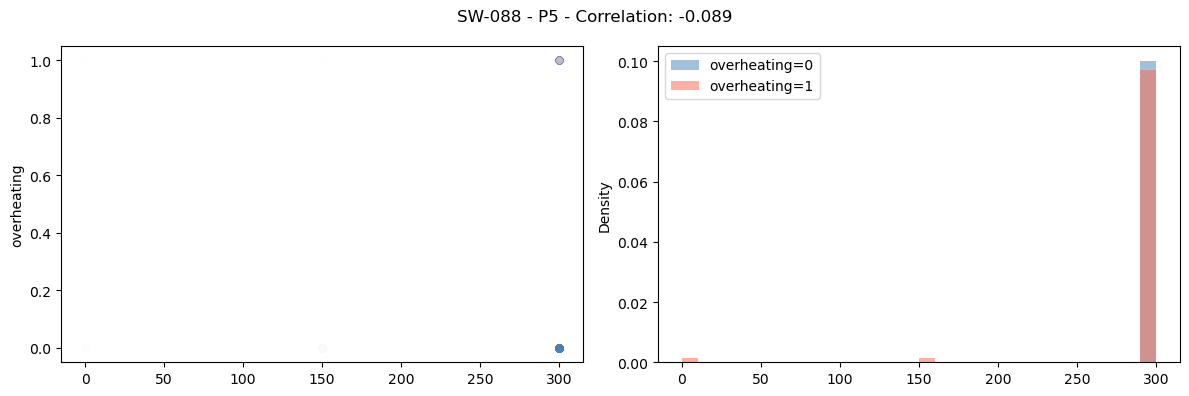

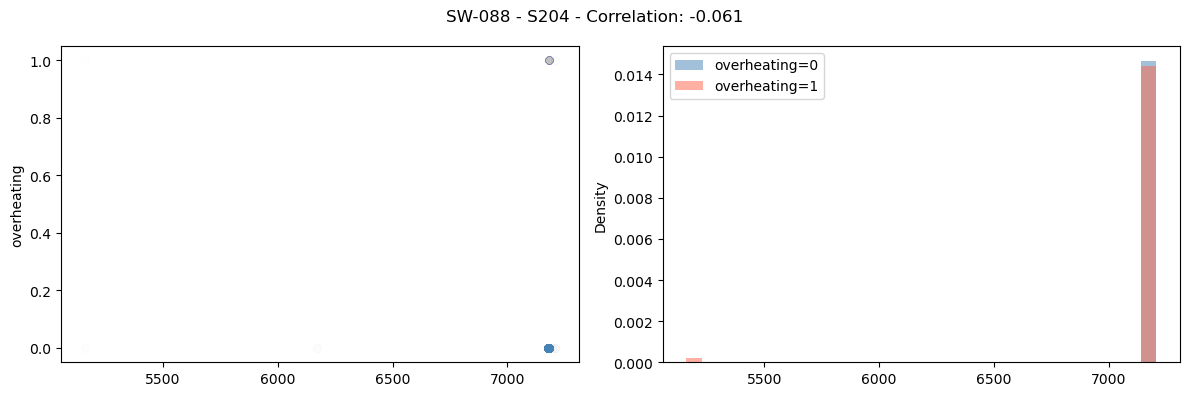

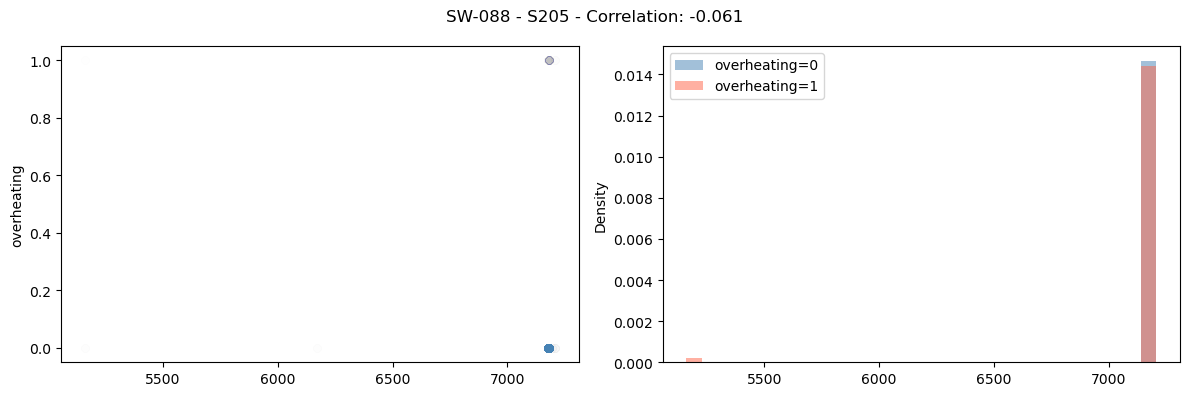

CPU times: user 1.13 s, sys: 39.2 ms, total: 1.17 s
Wall time: 22.1 s


In [36]:
%%time

for hw in [hw_to_inspect]: # Sostituire hw_to_inspect con list_hw
    alarm_corr = correlations(list_df_final[hw], useful_sensors[hw], 'overheating')
    
    # top_alarm_corr = alarm_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
    top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()

    plot_correlations(list_df_final[hw], 'overheating', top_alarm_corr, alarm_corr, hw)
    
    # print(top_anom_corr)

## Predictive modeling 

### Add predictive flag

In [121]:
df_final088 = list_df_final['SW-088'] # the only one in which there is overheating

In [123]:
def add_predictive(df, target, window_before_heating=30, join=True ,debug=False): #window_before_heating in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    df_pred = df.select("BlockID","when","window_start",target)
    df_pred = df.withColumn(f"prev_{target}", lag(target).over(w))
    df_pred = df_pred.withColumn(
        f"is_start_{target}",
        when(
            (col(target) == 1) &
            ((col(f"prev_{target}") != 1) | col(f"prev_{target}").isNull()),
            1
        ).otherwise(0)
    )


    df_pred = df_pred.withColumn(f"start_time_{target}", when(col(f"is_start_{target}") == 1, col("when")))

    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df_pred = df_pred.withColumn(
        f"next_start_{target}",
        first(f"start_time_{target}", ignorenulls=True).over(w_future)
    )

    window_seconds = window_before_heating * 60
    df_pred = df_pred.withColumn(
        f"predictive_{target}",
        when(
            (col(f"next_start_{target}").isNotNull()) &
            (col(target) == 0) &
            ((col(f"next_start_{target}") - col("when")) > 0) &
            ((col(f"next_start_{target}") - col("when")) <= window_seconds),
            1
        ).otherwise(0)
    )

    if not debug:
        df_pred = df_pred.select("BlockID","when",target,f"predictive_{target}")


    if join:
        return df.join( df_pred.select('when', f'predictive_{target}') , on='when', how='left' )
    else:
        return df_pred

In [126]:
target = "overheating"
df_final088 = add_predictive(df_final088, target, window_before_heating=30, debug=False, join=True )

In [ ]:

target = "flag_anomaly"
df_final088 = add_predictive(df_final088, target, window_before_heating=30, debug=False, join=True )

In [130]:
target = "flag_anomaly"
df_final088.where( (col("when") >= 1602565010) & (col("when") <= 1602654050) ).orderBy(col("when").asc()) \
    .select("window_start",target,f"predictive_{target}") .show(50)

+-------------------+------------+-----------------------+
|       window_start|flag_anomaly|predictive_flag_anomaly|
+-------------------+------------+-----------------------+
|2020-10-13 04:57:00|           0|                      0|
|2020-10-13 04:58:00|           0|                      0|
|2020-10-13 04:59:00|           0|                      0|
|2020-10-13 05:00:00|           0|                      0|
|2020-10-13 05:01:00|           0|                      0|
|2020-10-13 05:02:00|           0|                      0|
|2020-10-13 05:03:00|           0|                      0|
|2020-10-13 05:04:00|           0|                      0|
|2020-10-13 05:05:00|           0|                      1|
|2020-10-13 05:06:00|           0|                      1|
|2020-10-13 05:07:00|           0|                      1|
|2020-10-13 05:08:00|           0|                      1|
|2020-10-13 05:09:00|           0|                      1|
|2020-10-13 05:10:00|           0|                      

In [57]:
df_final088.where( (col("when") >= 1612537050) & (col("when") <= 1612540710) ).orderBy(col("when").asc()) \
    .select("window_start",target,f"predictive_{target}") .show(50)

[Stage 2417:============================>                           (1 + 1) / 2]

+-------------------+-----------+----------------+--------------------+----------------------+----------------------+----------------------+
|       window_start|overheating|prev_overheating|is_start_overheating|start_time_overheating|next_start_overheating|predictive_overheating|
+-------------------+-----------+----------------+--------------------+----------------------+----------------------+----------------------+
|2021-02-05 14:57:00|          0|               0|                   0|                  NULL|                  NULL|                     0|
|2021-02-05 14:59:00|          0|               0|                   0|                  NULL|                  NULL|                     0|
|2021-02-05 15:00:00|          0|               0|                   0|                  NULL|                  NULL|                     0|
|2021-02-05 15:37:00|          0|            NULL|                   0|                  NULL|            1612540530|                     1|
|2021-02-05 1

## SVM / RegressioneLogistica (su alarm)

In [163]:
top_corr_alarm = ["S53","S7","S172","S173","S39","S40"]

In [166]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np

# 1. Remove rows with NULL values in target columns
df_clean = df_final088.na.drop(subset=top_corr_alarm)
print(f"Original rows: {df_final088.count()}, Clean rows: {df_clean.count()}")

# 2. Assemble features into vector
assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features")
df_features = assembler.transform(df_clean)

# 3. Split data
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# 4. Create and train logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="predictive")
lr_model = lr.fit(train_data)

# 5. Display model coefficients
print("=== MODEL COEFFICIENTS ===")
print(f"Intercept: {lr_model.intercept:.4f}")
for feature, coeff in zip(top_corr_alarm, lr_model.coefficients):
    direction = "increases" if coeff > 0 else "decreases"
    print(f"{feature}: {coeff:.4f} - {direction} P(predictive=1)")

# 6. Make predictions
predictions = lr_model.transform(test_data)

# 7. Extract probability of predictive=1
get_prob_1 = udf(lambda prob: float(prob[1]), DoubleType())
predictions_with_prob = predictions.withColumn("prob_predictive_1", get_prob_1(col("probability")))

print("\n=== SAMPLE PREDICTIONS ===")
predictions_with_prob.select("predictive", "prob_predictive_1").show(10)

# 8. Model evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="predictive")
auc = evaluator.evaluate(predictions)
summary = lr_model.summary

print(f"\n=== MODEL PERFORMANCE ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {summary.accuracy:.4f}")

# 9. Manual probability calculation function
def calculate_probability(feature_values):
    """Calculate P(predictive=1) = 1 / (1 + exp(-(intercept + sum(coeff_i * x_i))))"""
    linear_combination = lr_model.intercept + sum(coeff * val for coeff, val in zip(lr_model.coefficients, feature_values))
    return 1 / (1 + np.exp(-linear_combination))

# Example usage
example_values = [0.0, 1.0, 0.5, 0.2, 1.1, 0.8]  # Replace with actual sensor values
manual_prob = calculate_probability(example_values)
print(f"\nManual calculation example: {manual_prob:.4f}")

Original rows: 191987, Clean rows: 185879


25/08/19 21:30:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

=== MODEL COEFFICIENTS ===
Intercept: -15.3732
S53: -2.4931 - decreases P(predictive=1)
S7: 8.9245 - increases P(predictive=1)
S172: 4.9154 - increases P(predictive=1)
S173: 3.3085 - increases P(predictive=1)
S39: 0.0057 - increases P(predictive=1)
S40: -0.0059 - decreases P(predictive=1)

=== SAMPLE PREDICTIONS ===


+----------+--------------------+
|predictive|   prob_predictive_1|
+----------+--------------------+
|         0|0.017112218708874583|
|         0|0.017008628111901403|
|         0| 0.01710435224478024|
|         0|0.017124025070843762|
|         0|0.017020364240471597|
|         0|0.017012539270886196|
|         0|0.017131900424966817|
|         0| 0.01703602479149824|
|         0|0.017124025070843762|
|         0| 0.01702819274682843|
+----------+--------------------+
only showing top 10 rows




=== MODEL PERFORMANCE ===
AUC: 0.7859


[Stage 3894:============================================>           (4 + 1) / 5]

Accuracy: 0.9928

Manual calculation example: 0.0346


Original rows: 191987, Clean rows: 185879


=== SVM HYPERPLANE ===
Intercept: -2.1363
Coefficients (hyperplane): [0.5016083527204447,0.5187872820349008,0.11583300041665565,-0.11229206641327225,-0.000427472703329341,0.0004234862393562192]

=== COEFFICIENT INTERPRETATION ===
S53: 0.5016 - pushes towards predictive=1
S7: 0.5188 - pushes towards predictive=1
S172: 0.1158 - pushes towards predictive=1
S173: -0.1123 - pushes towards predictive=0
S39: -0.0004 - pushes towards predictive=0
S40: 0.0004 - pushes towards predictive=1

=== SAMPLE PREDICTIONS ===


+----------+----------+
|predictive|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows




=== MODEL PERFORMANCE ===
AUC: 0.7597
Accuracy: 0.9932
Correct predictions: 36877/37128

=== COMBINATION COLUMN ADDED ===


+----------+-------------------+---+---+----+----+-----+-----+
|predictive|        combination|S53| S7|S172|S173|  S39|  S40|
+----------+-------------------+---+---+----+----+-----+-----+
|         0| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
|         1| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
|         1|-1.0000059141882096|1.0|1.0| 1.0| 0.0|102.0|103.0|
|         1| -1.000856873130895|1.0|1.0| 1.0| 0.0|103.0|102.0|
|         0| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
+----------+-------------------+---+---+----+----+-----+-----+
only showing top 5 rows




=== PLOTTING DATA ===
Data shape: (185879, 8)
Combination stats:
  Min: -2.2696
  Max: -0.9901
  Mean: -1.6098


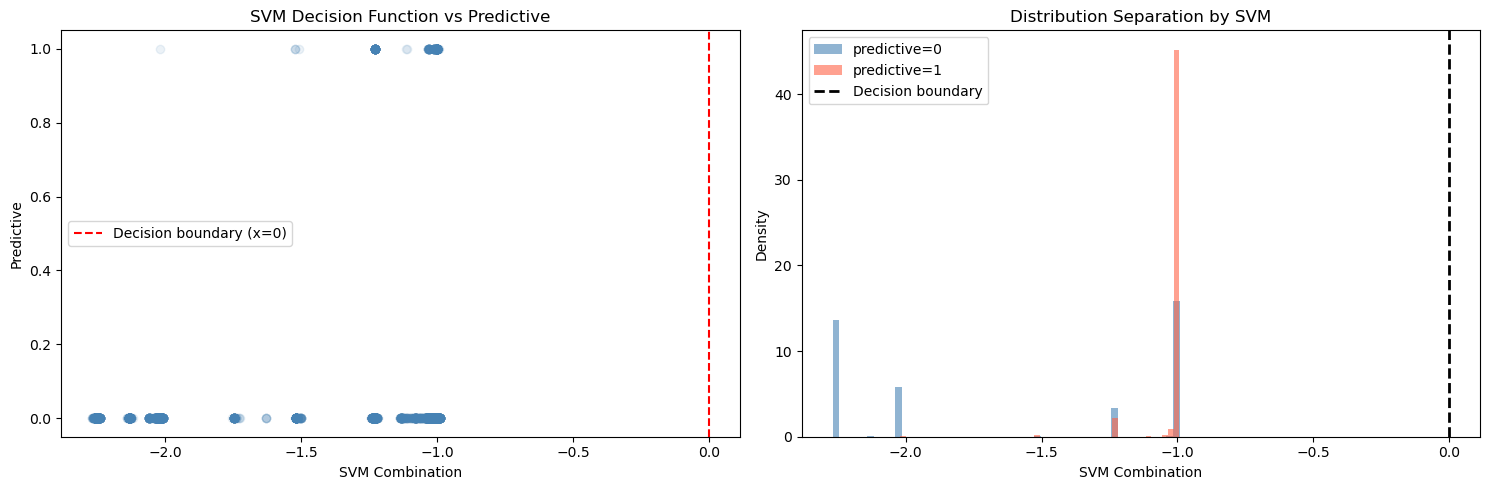


=== SEPARATION QUALITY ===
Class 0 (predictive=0): mean=-1.6140, std=0.5771
Class 1 (predictive=1): mean=-1.0146, std=0.0614
Mean difference: 0.5994
Decision boundary accuracy: 0.9929 (184557/185879)


In [168]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# 1. Remove rows with NULL values in target columns
df_clean = df_final088.na.drop(subset=top_corr_alarm)
print(f"Original rows: {df_final088.count()}, Clean rows: {df_clean.count()}")

# 2. Assemble features into vector
assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features")
df_features = assembler.transform(df_clean)

# 3. Split data
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# 4. Create and train SVM model
svc = LinearSVC(featuresCol="features", labelCol="predictive")
svc_model = svc.fit(train_data)

# 5. Display model coefficients (hyperplane)
print("=== SVM HYPERPLANE ===")
print(f"Intercept: {svc_model.intercept:.4f}")
print("Coefficients (hyperplane):", svc_model.coefficients)

print("\n=== COEFFICIENT INTERPRETATION ===")
for feature, coeff in zip(top_corr_alarm, svc_model.coefficients):
    direction = "pushes towards predictive=1" if coeff > 0 else "pushes towards predictive=0"
    print(f"{feature}: {coeff:.4f} - {direction}")

# 6. Make predictions
predictions = svc_model.transform(test_data)

print("\n=== SAMPLE PREDICTIONS ===")
predictions.select("predictive", "prediction").show(10)

# 7. Model evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="predictive")
auc = evaluator.evaluate(predictions)

# Count correct predictions
total_predictions = predictions.count()
correct_predictions = predictions.filter(col("predictive") == col("prediction")).count()
accuracy = correct_predictions / total_predictions

print(f"\n=== MODEL PERFORMANCE ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Correct predictions: {correct_predictions}/{total_predictions}")

# 8. Add combination column using SVM coefficients
from pyspark.sql.functions import lit

# Calculate linear combination: intercept + sum(coeff_i * x_i)
combination_expr = lit(svc_model.intercept)
for i, (feature, coeff) in enumerate(zip(top_corr_alarm, svc_model.coefficients)):
    combination_expr = combination_expr + (col(feature) * lit(float(coeff)))

df_with_combination = df_clean.withColumn("combination", combination_expr)

print(f"\n=== COMBINATION COLUMN ADDED ===")
df_with_combination.select("predictive", "combination", *top_corr_alarm).show(5)

# 9. Convert to Pandas for plotting
import matplotlib.pyplot as plt

pd_df = df_with_combination.select("predictive", "combination", *top_corr_alarm).toPandas()

print(f"\n=== PLOTTING DATA ===")
print(f"Data shape: {pd_df.shape}")
print(f"Combination stats:")
print(f"  Min: {pd_df['combination'].min():.4f}")
print(f"  Max: {pd_df['combination'].max():.4f}")
print(f"  Mean: {pd_df['combination'].mean():.4f}")

# 10. Create plots
# Plot 1: Scatter plot of combination vs predictive
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
ax1.scatter(pd_df['combination'], pd_df['predictive'], color="steelblue", alpha=0.1)
ax1.axvline(x=0, color='red', linestyle='--', label='Decision boundary (x=0)')
ax1.set_xlabel('SVM Combination')
ax1.set_ylabel('Predictive')
ax1.set_title('SVM Decision Function vs Predictive')
ax1.legend()

# Histogram showing separated distributions
for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
    subset = pd_df[pd_df['predictive'] == target_val]
    ax2.hist(subset['combination'], bins=50, alpha=0.6, color=color, 
             label=f"predictive={target_val}", density=True)

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision boundary')
ax2.set_xlabel('SVM Combination')
ax2.set_ylabel('Density')
ax2.set_title('Distribution Separation by SVM')
ax2.legend()

plt.tight_layout()
plt.show()

# 11. Print separation quality
negative_class = pd_df[pd_df['predictive'] == 0]['combination']
positive_class = pd_df[pd_df['predictive'] == 1]['combination']

print(f"\n=== SEPARATION QUALITY ===")
print(f"Class 0 (predictive=0): mean={negative_class.mean():.4f}, std={negative_class.std():.4f}")
print(f"Class 1 (predictive=1): mean={positive_class.mean():.4f}, std={positive_class.std():.4f}")
print(f"Mean difference: {positive_class.mean() - negative_class.mean():.4f}")

# Percentage of correct classifications using decision boundary at 0
correct_predictions = ((pd_df['combination'] > 0) == (pd_df['predictive'] == 1)).sum()
total_predictions = len(pd_df)
boundary_accuracy = correct_predictions / total_predictions
print(f"Decision boundary accuracy: {boundary_accuracy:.4f} ({correct_predictions}/{total_predictions})")

# <hr style="height:4px; background-color:black; border:none;" />